# Text Classification - UTS 

> Link PTA Trunojoyo : [PTA](https://docs.google.com/spreadsheets/d/1mVCTGsUb2Y2Sc9ATMIXcDm0WTefTNGCn/edit#gid=541328917)

## Process Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Data

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Prosaindata/tugas/Data_TA.csv")

In [4]:
df

,NPM,Judul,Abstrak,Prodi,Label
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,Sistem informasi akademik (SIAKAD) merupaka...,Teknik Informatika,RPL
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,Berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,Web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,Penjadwalan kuliah di Perguruan Tinggi me...,Teknik Informatika,komputasi
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,Seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,komputasi
...,...,...,...,...,...
848,160411100032,PENERAPAN ALGORITMA LONG-SHORT TERM MEMORY UNT...,Investasi saham selama ini memiliki resiko ker...,Teknik Informatika,komputasi
849,160411100182,SISTEM PENCARIAN TEKS AL-QURAN TERJEMAHAN BERB...,Information Retrieval (IR) merupakan pengambil...,Teknik Informatika,PBA
850,160411100077,KLASIFIKASI KOMPLEKSITAS VISUAL CITRA SAMPAH M...,Klasifikasi citra merupakan proses pengelompok...,Teknik Informatika,komputasi
851,160411100084,IDENTIFIKASI BINER ATRIBUT PEJALAN KAKI MENGGU...,Identifikasi atribut pejalan kaki merupakan sa...,Teknik Informatika,komputasi


### Data Information

In [5]:
df.isna().sum()

NPM         0
Judul       6
Abstrak    25
Prodi       0
Label      43
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   NPM      853 non-null    int64 
 1   Judul    847 non-null    object
 2   Abstrak  828 non-null    object
 3   Prodi    853 non-null    object
 4   Label    810 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.4+ KB


In [7]:
df = df.dropna()
df.isnull().sum()

NPM        0
Judul      0
Abstrak    0
Prodi      0
Label      0
dtype: int64

In [8]:
df.count()

NPM        810
Judul      810
Abstrak    810
Prodi      810
Label      810
dtype: int64

In [9]:
df

,NPM,Judul,Abstrak,Prodi,Label
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,Sistem informasi akademik (SIAKAD) merupaka...,Teknik Informatika,RPL
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,Berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,Web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,Penjadwalan kuliah di Perguruan Tinggi me...,Teknik Informatika,komputasi
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,Seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,komputasi
...,...,...,...,...,...
848,160411100032,PENERAPAN ALGORITMA LONG-SHORT TERM MEMORY UNT...,Investasi saham selama ini memiliki resiko ker...,Teknik Informatika,komputasi
849,160411100182,SISTEM PENCARIAN TEKS AL-QURAN TERJEMAHAN BERB...,Information Retrieval (IR) merupakan pengambil...,Teknik Informatika,PBA
850,160411100077,KLASIFIKASI KOMPLEKSITAS VISUAL CITRA SAMPAH M...,Klasifikasi citra merupakan proses pengelompok...,Teknik Informatika,komputasi
851,160411100084,IDENTIFIKASI BINER ATRIBUT PEJALAN KAKI MENGGU...,Identifikasi atribut pejalan kaki merupakan sa...,Teknik Informatika,komputasi


In [10]:
# Menghitung jumlah data pada masing-masing label
df['Label'].value_counts()

komputasi    573
RPL          198
PBA           39
Name: Label, dtype: int64

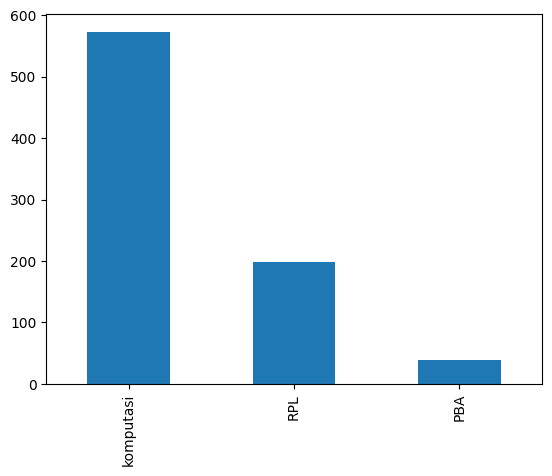

In [15]:
import matplotlib.pyplot as plt
df['Label'].value_counts().plot(kind='bar')
plt.show()

## Text Processing

### Text Cleaning

In [21]:
import re, string

In [17]:
# Text Cleaning
def cleaning(text):
    # HTML Tag Removal
    text = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});').sub('', str(text))

    # Case folding
    text = text.lower()

    # Trim text
    text = text.strip()

    # Remove punctuations, karakter spesial, and spasi ganda
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)

    # Number removal
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Mengubah text 'nan' dengan whitespace agar nantinya dapat dihapus
    text = re.sub('nan', '', text)

    return text

In [22]:
df['Abstrak'] = df['Abstrak'].apply(lambda x: cleaning(x))
df.head()

<ipython-input-22-17780d52a92e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abstrak'] = df['Abstrak'].apply(lambda x: cleaning(x))


,NPM,Judul,Abstrak,Prodi,Label
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,sistem informasi akademik siakad merupakan sis...,Teknik Informatika,RPL
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,penjadwalan kuliah di perguruan tinggi merupak...,Teknik Informatika,komputasi
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,komputasi


In [23]:
# Checkpoint: Export Hasil Text Cleaning
df.to_csv('dataPTA_cleaning.csv')

In [24]:
len(df)

810

### Remove Duplicate Values

In [25]:
#Mengecek apakah terdapat duplikasi data pada kolom judul
df[df['Judul'].duplicated()]

,NPM,Judul,Abstrak,Prodi,Label


In [26]:
#Mengecek apakah terdapat duplikasi data pada kolom abstrak
df[df['Abstrak'].duplicated()]

,NPM,Judul,Abstrak,Prodi,Label


## Tokenization
> Tokenization adalah proses untuk membagi teks yang dapat berupa kalimat, paragraf atau dokumen, menjadi token-token/bagian-bagian tertentu. 


In [30]:
import nltk
nltk.download('popular')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [31]:
# Tokenizing Abstrak
df['Abstrak_Tokens'] = df['Abstrak'].apply(lambda x: word_tokenize(x))
df[["Abstrak", "Abstrak_Tokens"]].head()

<ipython-input-31-cfde09665917>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abstrak_Tokens'] = df['Abstrak'].apply(lambda x: word_tokenize(x))


,Abstrak,Abstrak_Tokens
0,sistem informasi akademik siakad merupakan sis...,"[sistem, informasi, akademik, siakad, merupaka..."
1,berjalannya koneksi jaringan komputer dengan l...,"[berjalannya, koneksi, jaringan, komputer, den..."
2,web server adalah sebuah perangkat lunak serve...,"[web, server, adalah, sebuah, perangkat, lunak..."
3,penjadwalan kuliah di perguruan tinggi merupak...,"[penjadwalan, kuliah, di, perguruan, tinggi, m..."
4,seiring perkembangan teknologi yang ada diduni...,"[seiring, perkembangan, teknologi, yang, ada, ..."


## Stop Words Removal

In [32]:
from nltk.corpus import stopwords 
from itertools import chain

stop_words = set(chain(stopwords.words('indonesian'), stopwords.words('english')))

df['Abstrak_Tokens'] = df['Abstrak_Tokens'].apply(lambda x: [w for w in x if not w in stop_words])

<ipython-input-32-e35b348ce652>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abstrak_Tokens'] = df['Abstrak_Tokens'].apply(lambda x: [w for w in x if not w in stop_words])


In [34]:
df[["Abstrak", "Abstrak_Tokens"]].head()

,Abstrak,Abstrak_Tokens
0,sistem informasi akademik siakad merupakan sis...,"[sistem, informasi, akademik, siakad, sistem, ..."
1,berjalannya koneksi jaringan komputer dengan l...,"[berjalannya, koneksi, jaringan, komputer, lan..."
2,web server adalah sebuah perangkat lunak serve...,"[web, server, perangkat, lunak, server, berfun..."
3,penjadwalan kuliah di perguruan tinggi merupak...,"[penjadwalan, kuliah, perguruan, kompleks, per..."
4,seiring perkembangan teknologi yang ada diduni...,"[seiring, perkembangan, teknologi, didunia, mu..."


## Stemming
> Mengubah Kata Kerja Menjadi Kata Dasar

In [35]:
pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 8.9 MB/s eta 0:00:00


In [36]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm.auto import tqdm
tqdm.pandas()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [39]:
# Stemming abstrak
df['Abstrak_Tokens'] = df['Abstrak_Tokens'].progress_apply(lambda x: stemmer.stem(' '.join(x)).split(' '))

  0%|          | 0/810 [00:00<?, ?it/s]

<ipython-input-39-ae8957923b33>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abstrak_Tokens'] = df['Abstrak_Tokens'].progress_apply(lambda x: stemmer.stem(' '.join(x)).split(' '))


In [40]:
# Hasil stemming abstrak
df[["Abstrak", "Abstrak_Tokens"]].head()

,Abstrak,Abstrak_Tokens
0,sistem informasi akademik siakad merupakan sis...,"[sistem, informasi, akademik, siakad, sistem, ..."
1,berjalannya koneksi jaringan komputer dengan l...,"[jalan, koneksi, jaring, komputer, lancar, gan..."
2,web server adalah sebuah perangkat lunak serve...,"[web, server, perangkat, lunak, server, berfun..."
3,penjadwalan kuliah di perguruan tinggi merupak...,"[jadwal, kuliah, guru, kompleks, masalah, vari..."
4,seiring perkembangan teknologi yang ada diduni...,"[iring, kembang, teknologi, dunia, muncul, tek..."


## Export Cleaned Data

In [41]:
df

,NPM,Judul,Abstrak,Prodi,Label,Abstrak_Tokens
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,sistem informasi akademik siakad merupakan sis...,Teknik Informatika,RPL,"[sistem, informasi, akademik, siakad, sistem, ..."
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL,"[jalan, koneksi, jaring, komputer, lancar, gan..."
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL,"[web, server, perangkat, lunak, server, berfun..."
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,penjadwalan kuliah di perguruan tinggi merupak...,Teknik Informatika,komputasi,"[jadwal, kuliah, guru, kompleks, masalah, vari..."
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,komputasi,"[iring, kembang, teknologi, dunia, muncul, tek..."
...,...,...,...,...,...,...
848,160411100032,PENERAPAN ALGORITMA LONG-SHORT TERM MEMORY UNT...,investasi saham selama ini memiliki resiko ker...,Teknik Informatika,komputasi,"[investasi, saham, milik, resiko, rugi, dikare..."
849,160411100182,SISTEM PENCARIAN TEKS AL-QURAN TERJEMAHAN BERB...,information retrieval ir merupakan pengambilan...,Teknik Informatika,PBA,"[information, retrieval, ir, ambil, informasi,..."
850,160411100077,KLASIFIKASI KOMPLEKSITAS VISUAL CITRA SAMPAH M...,klasifikasi citra merupakan proses pengelompok...,Teknik Informatika,komputasi,"[klasifikasi, citra, proses, kelompok, piksel,..."
851,160411100084,IDENTIFIKASI BINER ATRIBUT PEJALAN KAKI MENGGU...,identifikasi atribut pejalan kaki merupakan sa...,Teknik Informatika,komputasi,"[identifikasi, atribut, pejal, kaki, salah, te..."


In [42]:
df['Abstrak_Tokens'] = df['Abstrak_Tokens'].apply(lambda x: ' '.join(x))

df.to_csv('cleanedPTA.csv')

<ipython-input-42-8b3dca0c3d09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abstrak_Tokens'] = df['Abstrak_Tokens'].apply(lambda x: ' '.join(x))


## Classification

### Load Preprocessed Data

In [43]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/cleanedPTA.csv', index_col=0)
df.head()

,NPM,Judul,Abstrak,Prodi,Label,Abstrak_Tokens
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,sistem informasi akademik siakad merupakan sis...,Teknik Informatika,RPL,sistem informasi akademik siakad sistem inform...
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL,jalan koneksi jaring komputer lancar ganggu ha...
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL,web server perangkat lunak server berfungsimen...
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,penjadwalan kuliah di perguruan tinggi merupak...,Teknik Informatika,komputasi,jadwal kuliah guru kompleks masalah variabel t...
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,komputasi,iring kembang teknologi dunia muncul teknologi...


### Feature Extraction


> **Bag of Words**

```Bag of Words (BoW) merupakan salah satu metode paling sederhana dalam mengubah data teks menjadi vektor yang dapat dipahami oleh komputer. Metode ini sejatinya hanya menghitung frekuensi kemunculan kata pada seluruh dokumen.```

> Sebelum data direduksi dimensinya, data string diubah menjadi data integer dalam bentuk vector

In [98]:
X = df['Abstrak_Tokens']
y = df['Label']

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
# Multiple documents
text = (X)
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(sorted(vectorizer.vocabulary_))

['aalysis', 'aam', 'abad', 'abadi', 'abai', 'abdi', 'ability', 'abjad', 'absah', 'absensi', 'absolut', 'absolute', 'abstract', 'abstrak', 'abstrakdalam', 'abstrakdata', 'abstrakdi', 'abstrake', 'abstrakginjal', 'abstrakkendaraan', 'abstrakkondisi', 'abstrakmedia', 'abstrakobat', 'abstrakpada', 'abstrakpemain', 'abstrakpemanfaatan', 'abstrakpembinaan', 'abstrakpemilihan', 'abstrakpencatatan', 'abstrakpendidikan', 'abstrakpenilaian', 'abstrakpenjiplakan', 'abstrakperkembangan', 'abstrakpertumbuhan', 'abstrakpuskesmas', 'abstraksaat', 'abstraksalah', 'abstraksetiap', 'abstraksi', 'abstraksidiabetic', 'abstrakteknologi', 'abu', 'acak', 'acap', 'accelerated', 'accelerometer', 'acceptance', 'access', 'accessibility', 'accounting', 'accuracy', 'accuracynya', 'achmad', 'aclam', 'acne', 'acommerce', 'action', 'actionscript', 'active', 'actor', 'acu', 'acute', 'ada', 'adaboost', 'adaempat', 'adalahdata', 'adalahna', 'adalahperangkat', 'adamenunjukkan', 'adanhya', 'adaptasi', 'adaptif', 'adaptive

In [50]:
# encode document
vector = vectorizer.fit_transform(text)
count_tokens = sorted(vectorizer.vocabulary_)
# summarize encoded vector
df_countvect = pd.DataFrame(data = vector.toarray(),columns = count_tokens)
df_countvect

,aalysis,aam,abad,abadi,abai,abdi,ability,abjad,absah,absensi,...,zara,zat,zcz,zf,zona,zone,zoning,zoom,zucara,zungu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
vector.shape

(810, 6446)

> Jumlah data yang sudah dilakukan ekstraksi fitur yaitu sebanyak :
- 810 baris
- 6446 kolom

> **PCA**

```Principal Component Analysis (PCA) adalah salah satu metode reduksi dimensi pada machine learning. PCA akan memilih œvariabel-variabel yang mampu menjelaskan sebagian besar variabilitas data. PCA mengurangi dimensi dengan membentuk variabel-variabel baru yang disebut Principal Components.```

In [55]:
# Impor library yang dibutuhkan
from sklearn.decomposition import PCA

# Inisialisasi objek PCA dengan 4 komponen
pca = PCA(n_components=4)

# Melakukan fit transform pada data
X_pca = pca.fit_transform(df_countvect)

In [56]:
X_pca.shape

(810, 4)

> Jumlah data yang sudah dilakukan reduksi dimensi yaitu sebanyak :
- 810 baris
- 4 kolom

### Split Data

In [94]:
from sklearn.model_selection import train_test_split
#Nilai X training dan Nilai X testing
X_train, X_test = train_test_split(X_pca,test_size=0.3, random_state=1)
#Nilai Y training dan Nilai Y testing
y_train, y_test = train_test_split(y, test_size=0.3, random_state=1)

### Naive Bayes

In [96]:
#Model Select
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test) 
accuracy_score(y_test, y_pred)

0.7489711934156379

### K-NN

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

modelKNN = KNeighborsClassifier(n_neighbors=10)
modelKNN.fit(X_train, y_train)
y_pred = modelKNN.predict(X_test)
accuracy_score(y_test, y_pred)

0.8106995884773662

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         PBA       0.00      0.00      0.00        10
         RPL       0.62      0.69      0.66        65
   komputasi       0.84      0.82      0.83       168

    accuracy                           0.75       243
   macro avg       0.49      0.50      0.49       243
weighted avg       0.75      0.75      0.75       243

